# Comp Architecture Experiment Results

In [1]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.api as sms

from db import conn

In [2]:
%matplotlib inline

In [3]:
sns.set_style("whitegrid")

In [4]:
cursor = conn.cursor()
experiment_rows = [r for r in cursor.execute("""
    select g.name, args, dev_metric, test_metric from experiments e
    join experiment_groups g on e.group_id=g.gid
    where g.name=?""", ('mpcnn-v2-comp-fix-params-and-seed',))]

In [5]:
len(experiment_rows)

120

In [6]:
experiment_results = {
    'trecqa': [],
    'wikiqa': [],
    'sick': []
}

for row in experiment_rows:
    args = json.loads(row[1])
    dev_metrics = json.loads(row[2])
    test_metrics = json.loads(row[3])
    dataset = args['dataset']
    
    if args['arch'] == 'mpcnn_comp_unit1_only':
        arch = 'U1'
    elif args['arch'] == 'mpcnn_comp_unit2_only':
        arch = 'U2'
    elif args['arch'] == 'mpcnn_comp_horiz_only':
        arch = 'Horiz'
    elif args['arch'] == 'mpcnn_comp_vert_only':
        arch = 'Vert'
    elif args['arch'] == 'mpcnn_comp_vert_holistic_only':
        arch = 'Vert. Holistic'
    elif args['arch'] == 'mpcnn_comp_cosine':
        arch = 'Cosine'
    elif args['arch'] == 'mpcnn_comp_euclidean':
        arch = 'Euclidean'
    elif args['arch'] == 'mpcnn_comp_abs_diff':
        arch = 'AbsDiff'
    else:
        arch = 'MP-CNN'
    
    res_base = {
        'arch': arch,
        'dataset': dataset,
        'seed': args['seed']
    }
    
    results = []
    
    if dataset in ('trecqa', 'wikiqa'):
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MAP', 'metric_val': dev_metrics['map']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MRR', 'metric_val': dev_metrics['mrr']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MAP', 'metric_val': test_metrics['map']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MRR', 'metric_val': test_metrics['mrr']}})
    elif dataset == 'sick':
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'pearson', 'metric_val': dev_metrics['pearson']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'spearman', 'metric_val': dev_metrics['spearman']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'pearson', 'metric_val': test_metrics['pearson']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'spearman', 'metric_val': test_metrics['spearman']}})
    
    experiment_results[dataset].extend(results)

In [7]:
trecqa = pd.DataFrame(experiment_results['trecqa'])
wikiqa = pd.DataFrame(experiment_results['wikiqa'])
sick = pd.DataFrame(experiment_results['sick'])

In [8]:
trecqa.head(8)

,arch,dataset,metric_name,metric_val,seed,split
0,Horiz,trecqa,MAP,0.7884,208271,dev
1,Horiz,trecqa,MRR,0.8633,208271,dev
2,Horiz,trecqa,MAP,0.7613,208271,test
3,Horiz,trecqa,MRR,0.8226,208271,test
4,MP-CNN,trecqa,MAP,0.8232,208271,dev
5,MP-CNN,trecqa,MRR,0.9090,208271,dev
6,MP-CNN,trecqa,MAP,0.7686,208271,test
7,MP-CNN,trecqa,MRR,0.8305,208271,test


In [9]:
archs = ['MP-CNN', 'Horiz', 'Vert', 'Vert. Holistic']
#archs = ['MP-CNN', 'Cosine', 'Euclidean', 'AbsDiff']
def compare_change_to_baseline(df, metric):
    changes = {'MP-CNN': 'baseline'}
    config_ids = df['seed'].unique()
    for arch in archs:
        if arch == 'MP-CNN':
            continue

        diffs = []
        for config_id in config_ids:
            baseline = df[(df['seed'] == config_id) & (df['arch'] == 'MP-CNN')].iloc[0]['metric_val']
            conf_perf = df[(df['seed'] == config_id) & (df['arch'] == arch)].iloc[0]['metric_val']
            diffs.append(conf_perf - baseline)

        print(f'Architecture: {arch} comparison only')
        print(f'Median of {metric} change compared with MP-CNN baseline: {np.median(diffs):.4f}')
        print(f'Mean of {metric} change compared with MP-CNN baseline: {np.mean(diffs):.4f}')
        diff = np.median(diffs)
        changes[arch] = f'+{diff:.4f}' if diff > 0 else f'{diff:.4f}'
    
    return changes

## TrecQA

In [10]:
trec_map_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'test')]
trec_mrr_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'test')]
trec_map_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'dev')]
trec_mrr_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'dev')]

In [11]:
trec_map_intervals = {}
for arch in trec_map_vs_archs_test['arch'].unique():
    arr = trec_map_vs_archs_test[trec_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    trec_map_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

Horiz: (0.7255, 0.7562)
MP-CNN: (0.6811, 0.8095)
Vert: (0.7773, 0.7942)
Vert. Holistic: (0.7612, 0.7859)


In [12]:
trec_mrr_intervals = {}
for arch in trec_mrr_vs_archs_test['arch'].unique():
    arr = trec_mrr_vs_archs_test[trec_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    trec_mrr_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

Horiz: (0.8044, 0.8280)
MP-CNN: (0.7408, 0.8707)
Vert: (0.8276, 0.8576)
Vert. Holistic: (0.8218, 0.8440)


In [13]:
trec_map_delta = compare_change_to_baseline(trec_map_vs_archs_test, 'MAP')

Architecture: Horiz comparison only
Median of MAP change compared with MP-CNN baseline: -0.0261
Mean of MAP change compared with MP-CNN baseline: -0.0044
Architecture: Vert comparison only
Median of MAP change compared with MP-CNN baseline: 0.0168
Mean of MAP change compared with MP-CNN baseline: 0.0404
Architecture: Vert. Holistic comparison only
Median of MAP change compared with MP-CNN baseline: -0.0024
Mean of MAP change compared with MP-CNN baseline: 0.0283


In [14]:
trec_map_vs_archs_test[trec_map_vs_archs_test.arch == 'Horiz']

,arch,dataset,metric_name,metric_val,seed,split
2,Horiz,trecqa,MAP,0.7613,208271,test
26,Horiz,trecqa,MAP,0.7155,839969,test
38,Horiz,trecqa,MAP,0.7821,207088,test
54,Horiz,trecqa,MAP,0.7174,673071,test
66,Horiz,trecqa,MAP,0.7564,905578,test
86,Horiz,trecqa,MAP,0.7249,590204,test
102,Horiz,trecqa,MAP,0.7238,918301,test
106,Horiz,trecqa,MAP,0.7469,796240,test
130,Horiz,trecqa,MAP,0.7412,753071,test
154,Horiz,trecqa,MAP,0.7392,490149,test


In [15]:
trec_mrr_delta = compare_change_to_baseline(trec_mrr_vs_archs_test, 'MRR')

Architecture: Horiz comparison only
Median of MRR change compared with MP-CNN baseline: -0.0118
Mean of MRR change compared with MP-CNN baseline: 0.0104
Architecture: Vert comparison only
Median of MRR change compared with MP-CNN baseline: 0.0179
Mean of MRR change compared with MP-CNN baseline: 0.0368
Architecture: Vert. Holistic comparison only
Median of MRR change compared with MP-CNN baseline: 0.0061
Mean of MRR change compared with MP-CNN baseline: 0.0271


## WikiQA

In [16]:
wikiqa_map_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'test')]
wikiqa_mrr_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'test')]
wikiqa_map_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'dev')]
wikiqa_mrr_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'dev')]

In [17]:
wikiqa_map_intervals = {}
for arch in wikiqa_map_vs_archs_test['arch'].unique():
    arr = wikiqa_map_vs_archs_test[wikiqa_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    wikiqa_map_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN: (0.5790, 0.7327)
Horiz: (0.6865, 0.6962)
Vert. Holistic: (0.6917, 0.7022)
Vert: (0.6984, 0.7092)


In [18]:
wikiqa_mrr_intervals = {}
for arch in wikiqa_mrr_vs_archs_test['arch'].unique():
    arr = wikiqa_mrr_vs_archs_test[wikiqa_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    wikiqa_mrr_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN: (0.5857, 0.7465)
Horiz: (0.7000, 0.7094)
Vert. Holistic: (0.7047, 0.7173)
Vert: (0.7106, 0.7224)


In [19]:
wikiqa_map_delta = compare_change_to_baseline(wikiqa_map_vs_archs_test, 'MAP')

Architecture: Horiz comparison only
Median of MAP change compared with MP-CNN baseline: -0.0168
Mean of MAP change compared with MP-CNN baseline: 0.0355
Architecture: Vert comparison only
Median of MAP change compared with MP-CNN baseline: -0.0040
Mean of MAP change compared with MP-CNN baseline: 0.0479
Architecture: Vert. Holistic comparison only
Median of MAP change compared with MP-CNN baseline: -0.0123
Mean of MAP change compared with MP-CNN baseline: 0.0411


In [20]:
wikiqa_mrr_delta = compare_change_to_baseline(wikiqa_mrr_vs_archs_test, 'MRR')

Architecture: Horiz comparison only
Median of MRR change compared with MP-CNN baseline: -0.0182
Mean of MRR change compared with MP-CNN baseline: 0.0386
Architecture: Vert comparison only
Median of MRR change compared with MP-CNN baseline: -0.0038
Mean of MRR change compared with MP-CNN baseline: 0.0504
Architecture: Vert. Holistic comparison only
Median of MRR change compared with MP-CNN baseline: -0.0142
Mean of MRR change compared with MP-CNN baseline: 0.0449


## SICK

In [21]:
sick_pearson_vs_archs_test = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'test')]
sick_spearman_vs_archs_test = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'test')]
sick_pearson_vs_archs_dev = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'dev')]
sick_spearman_vs_archs_dev = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'dev')]

In [22]:
sick_pearson_intervals = {}
for arch in sick_pearson_vs_archs_test['arch'].unique():
    arr = sick_pearson_vs_archs_test[sick_pearson_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    sick_pearson_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN: (0.8660, 0.8714)
Horiz: (0.8561, 0.8587)
Vert: (0.8643, 0.8707)
Vert. Holistic: (0.8620, 0.8677)


In [23]:
sick_spearman_intervals = {}
for arch in sick_spearman_vs_archs_test['arch'].unique():
    arr = sick_spearman_vs_archs_test[sick_spearman_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    sick_spearman_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN: (0.8037, 0.8098)
Horiz: (0.7948, 0.7987)
Vert: (0.7990, 0.8065)
Vert. Holistic: (0.7973, 0.8043)


In [24]:
sick_pearson_delta = compare_change_to_baseline(sick_pearson_vs_archs_test, 'pearson')

Architecture: Horiz comparison only
Median of pearson change compared with MP-CNN baseline: -0.0115
Mean of pearson change compared with MP-CNN baseline: -0.0113
Architecture: Vert comparison only
Median of pearson change compared with MP-CNN baseline: -0.0011
Mean of pearson change compared with MP-CNN baseline: -0.0012
Architecture: Vert. Holistic comparison only
Median of pearson change compared with MP-CNN baseline: -0.0036
Mean of pearson change compared with MP-CNN baseline: -0.0038


In [25]:
sick_spearman_delta = compare_change_to_baseline(sick_spearman_vs_archs_test, 'spearman')

Architecture: Horiz comparison only
Median of spearman change compared with MP-CNN baseline: -0.0100
Mean of spearman change compared with MP-CNN baseline: -0.0100
Architecture: Vert comparison only
Median of spearman change compared with MP-CNN baseline: -0.0038
Mean of spearman change compared with MP-CNN baseline: -0.0040
Architecture: Vert. Holistic comparison only
Median of spearman change compared with MP-CNN baseline: -0.0062
Mean of spearman change compared with MP-CNN baseline: -0.0059


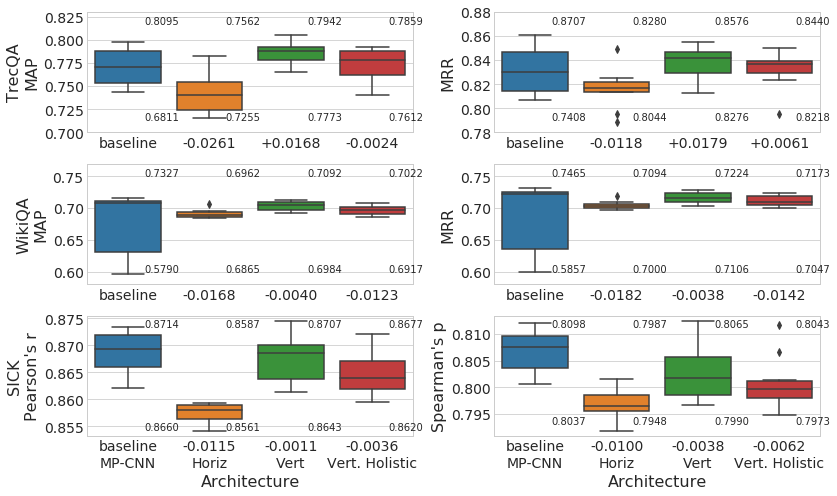

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 7)
title_size = 18
axis_size = 16
tick_size = 14

ax = plt.subplot(321)
sns.boxplot(x='arch', y='metric_val', data=trec_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('TrecQA\nMAP', fontsize=axis_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.7, 0.83))
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([trec_map_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), trec_map_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), trec_map_intervals[a][1])

ax = plt.subplot(322)
sns.boxplot(x='arch', y='metric_val', data=trec_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=axis_size)
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.78, 0.88))
ax.xaxis.set_ticklabels([trec_mrr_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), trec_mrr_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), trec_mrr_intervals[a][1])

ax = plt.subplot(323)
sns.boxplot(x='arch', y='metric_val', data=wikiqa_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('WikiQA\nMAP', fontsize=axis_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.58, 0.77))
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([wikiqa_map_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), wikiqa_map_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), wikiqa_map_intervals[a][1])

ax = plt.subplot(324)
sns.boxplot(x='arch', y='metric_val', data=wikiqa_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=axis_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.58, 0.77))
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([wikiqa_mrr_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), wikiqa_mrr_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), wikiqa_mrr_intervals[a][1])

ax = plt.subplot(325)
sns.boxplot(x='arch', y='metric_val', data=sick_pearson_vs_archs_test, order=archs, ax=ax)
plt.ylabel("SICK\nPearson's r", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([sick_pearson_delta[a] + '\n' + a for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.05*(ylim[1] - ylim[0]), sick_pearson_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), sick_pearson_intervals[a][1])

ax = plt.subplot(326)
sns.boxplot(x='arch', y='metric_val', data=sick_spearman_vs_archs_test, order=archs, ax=ax)
plt.ylabel("Spearman's p", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([sick_spearman_delta[a] + '\n' + a for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), sick_spearman_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), sick_spearman_intervals[a][1])
plt.tight_layout()
# plt.subplots_adjust(top=0.8, hspace=0.2)
plt.savefig('comp_algo_arch_violin.pdf')